In [1]:
from data import cifar10, swiss_roll_data, get_word2vec_data, plot_swiss_roll, word_embedding_plot, cifar10_latent_plot
from model import VAE
from train import train_vae, train_resnet18
import torch
import torchvision
import numpy as np

## Swiss Roll

In [2]:
nr_samples = 5000
data_loader, data, time = swiss_roll_data(split=[nr_samples, 1500, 1500], batch_size=nr_samples)
train_loader, val_loader, test_loader = data_loader
train_data, val_data, test_data = data 
train_time, val_time, test_time = time

100%|██████████| 120/120 [00:06<00:00, 18.91it/s]


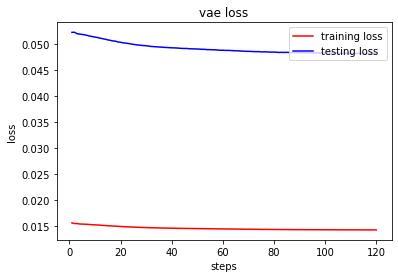

In [4]:
vae = VAE(input_dimension=3, hidden_dims=200, latent_dims=2)
train_vae(120, vae, train_loader, test_loader, lr=0.001)

c:\D\TUM_crowd_modeling\final_proj\src\data.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


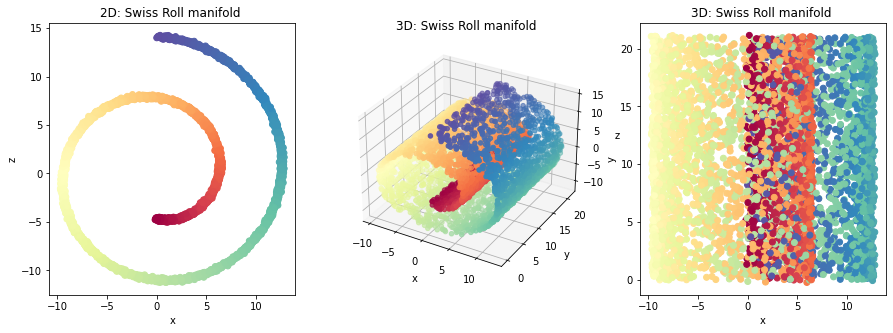

In [5]:
latent_data = vae.encoder(train_data)
plot_swiss_roll(nr_samples, train_data, train_time, latent_data)

## Word2vec

In [3]:
# this may takes 1 min.
nr_samples = 5000
loader, embedding, words = get_word2vec_data(split=[nr_samples, 1000, 1000], seed=3407, batch_size=32)
train_loader, val_loader, test_loader = loader
train_embeddings, val_embeddings, test_embeddings = embedding
train_words, val_words, test_words = words

C:\Users\huwenbin/gensim-data


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


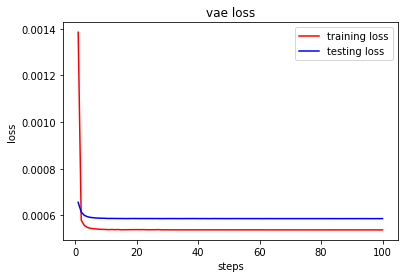

In [4]:
vae = VAE(input_dimension=300, hidden_dims=256, latent_dims=2)
train_vae(100, vae, train_loader, test_loader, lr=0.001)

In [5]:
torch.save(vae, './weights/word2vec_vae.pt')

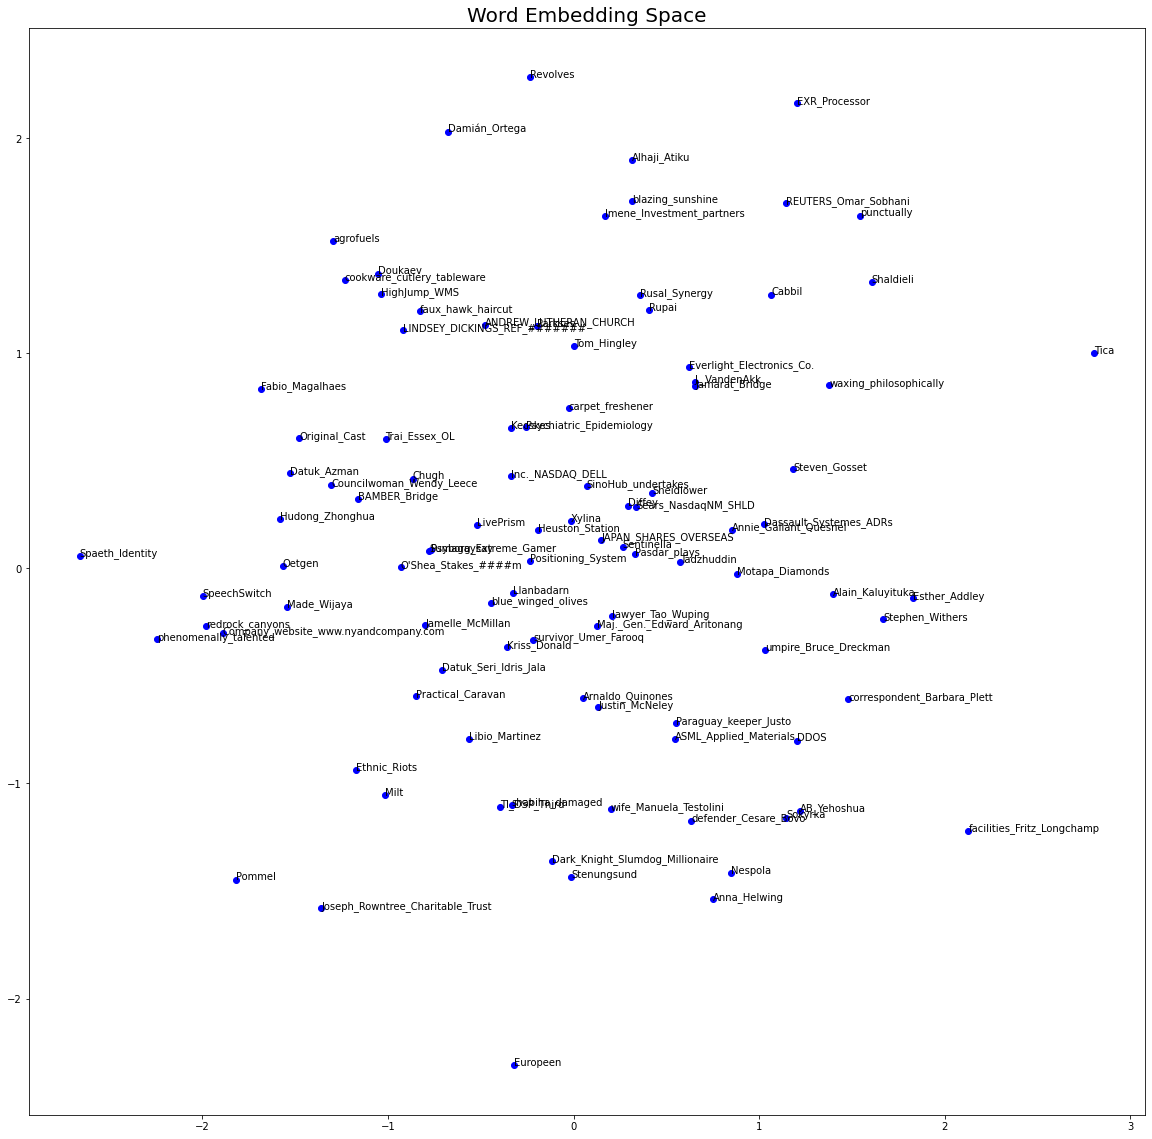

In [25]:
num_samples = 100
index = np.random.randint(0, nr_samples, num_samples)
latent_vec = vae.encoder(torch.tensor(train_embeddings[index]))
words = [train_words[i] for i in index]
word_embedding_plot(latent_vec.detach().numpy(), words)

## Cifar 10

In [2]:
train_loader, val_loader, test_loader = cifar10(train_val_split = [45000, 5000], batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10/10 [11:07<00:00, 66.77s/it]


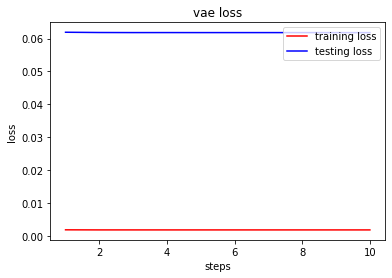

In [3]:
epochs = 10

vae = VAE(input_dimension=32*32*3, hidden_dims=256, latent_dims=2)
train_vae(epochs, vae, train_loader, test_loader, lr=0.001, is_cifar=True)

In [5]:
torch.save(vae, './weights/cifar10_vae.pt')

In [3]:
vae = torch.load('./weights/cifar10_vae.pt')

In [6]:
latent = torch.tensor([])
y_ = torch.tensor([])
for (x, y) in train_loader:
    x = x.reshape((len(x), -1))
    z = vae.encoder(x)
    latent = torch.concat([latent, z], dim=0)
    y_ = torch.concat([y_, y], dim=0)
latent = latent.detach().numpy()
y_ = y_.detach().numpy()

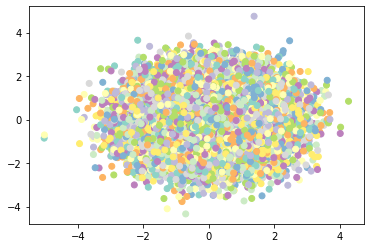

In [7]:
cifar10_latent_plot(latent, y_)

## performance

In [14]:
model = torchvision.models.resnet18(False)
model.fc = torch.nn.Linear(512, 10)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_resnet18(epochs, train_loader, batch_size=32)